In [1]:
%%capture

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import re
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -------------------------------
# Load Datasets
# -------------------------------
def load_datasets():
    dicom_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv'
    calc_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv'
    mass_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv'
    
    dicom_df = pd.read_csv(dicom_path)
    calc_df = pd.read_csv(calc_path)
    mass_df = pd.read_csv(mass_path)
    
    return dicom_df, calc_df, mass_df

# -------------------------------
# Preprocess DICOM DataFrame
# -------------------------------
def preprocess_dicom(dicom_df):
    # Filter out TEST dataset records
    dicom_df = dicom_df[~dicom_df['PatientID'].str.contains('Test', case=False, na=False)]
    
    # Clean and standardize PatientID
    dicom_df['CleanPatientID'] = (
        dicom_df['PatientID']
        .apply(lambda x: re.sub(r'(_\d+)$', '', x))  # Remove suffix like _1
        .str.strip()
        .str.upper()
    )
    
    # Extract CorePatientID (e.g., P_00001)
    dicom_df['CorePatientID'] = dicom_df['CleanPatientID'].apply(
        lambda x: re.search(r'(P_\d+)', x).group(1) if pd.notnull(x) and re.search(r'(P_\d+)', x) else x
    )
    
    # Extract Laterality and View
    dicom_df['Laterality'] = dicom_df['CleanPatientID'].apply(
        lambda x: 'LEFT' if 'LEFT' in x else 'RIGHT' if 'RIGHT' in x else None
    )
    dicom_df['View'] = dicom_df['CleanPatientID'].apply(
        lambda x: 'CC' if 'CC' in x else 'MLO' if 'MLO' in x else None
    )
    
    return dicom_df

# -------------------------------
# Preprocess Pathology DataFrames
# -------------------------------
def preprocess_pathology(df, pathology_type):
    """
    Standardizes and renames columns in pathology DataFrames.
    
    Parameters:
        df (pd.DataFrame): The pathology DataFrame (calc or mass).
        pathology_type (str): Type of pathology ('calc' or 'mass') for logging.
        
    Returns:
        pd.DataFrame: Processed DataFrame.
    """
    # Standardize relevant columns
    df['patient_id'] = df['patient_id'].str.strip().str.upper()
    df['left or right breast'] = df['left or right breast'].str.strip().str.upper()
    df['image view'] = df['image view'].str.strip().str.upper()
    
    # Rename columns for consistency
    df.rename(
        columns={
            'breast density': 'breast_density',
            'image file path': 'corrected_image_path'
        },
        inplace=True
    )
    
    # Log processing completion
    print(f"Preprocessed {pathology_type} DataFrame with {df.shape[0]} records.")
    
    return df

# -------------------------------
# Merge Pathology Data with DICOM Data
# -------------------------------
def merge_pathology(dicom_df, pathology_df, pathology_type):
    """
    Merges a pathology DataFrame with the DICOM DataFrame.
    
    Parameters:
        dicom_df (pd.DataFrame): The DICOM DataFrame.
        pathology_df (pd.DataFrame): The pathology DataFrame (calc or mass).
        pathology_type (str): Type of pathology ('calc' or 'mass') for logging.
        
    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    merged_df = dicom_df.merge(
        pathology_df[['patient_id', 'breast_density', 'left or right breast', 'image view', 
                     'pathology', 'corrected_image_path']],
        left_on=['CorePatientID', 'Laterality', 'View'],
        right_on=['patient_id', 'left or right breast', 'image view'],
        how='left',
        suffixes=('', f'_{pathology_type}')
    )
    print(f"Merged DICOM with {pathology_type} DataFrame: {merged_df.shape[0]} records.")
    return merged_df

# -------------------------------
# Combine and Clean Merged Data
# -------------------------------
def combine_and_clean(calc_merged, mass_merged, dicom_df, calc_df, mass_df):
    """
    Combines merged CALC and MASS DataFrames and fills missing pathology data.
    
    Parameters:
        calc_merged (pd.DataFrame): Merged CALC DataFrame.
        mass_merged (pd.DataFrame): Merged MASS DataFrame.
        dicom_df (pd.DataFrame): The original DICOM DataFrame.
        calc_df (pd.DataFrame): The original CALC DataFrame.
        mass_df (pd.DataFrame): The original MASS DataFrame.
        
    Returns:
        pd.DataFrame: Combined and cleaned DataFrame.
    """
    # Combine CALC and MASS DataFrames
    combined_df = pd.concat([calc_merged, mass_merged], axis=0).reset_index(drop=True)
    print(f"Combined CALC and MASS DataFrames: {combined_df.shape[0]} records.")
    
    # Fallback merges to fill missing 'pathology'
    fallback_calc = dicom_df.merge(
        calc_df[['patient_id', 'pathology']],
        left_on='CorePatientID',
        right_on='patient_id',
        how='left'
    )
    fallback_mass = dicom_df.merge(
        mass_df[['patient_id', 'pathology']],
        left_on='CorePatientID',
        right_on='patient_id',
        how='left'
    )
    
    # Fill missing 'pathology' values
    combined_df['pathology'] = combined_df['pathology'].fillna(fallback_calc['pathology'])
    combined_df['pathology'] = combined_df['pathology'].fillna(fallback_mass['pathology'])
    
    # Map pathology to cancer labels
    pathology_mapping = {
        'MALIGNANT': 1,
        'BENIGN': 0,
        'BENIGN_WITHOUT_CALLBACK': 2
    }
    combined_df['cancer_label'] = combined_df['pathology'].map(pathology_mapping)
    
    # Create a 'visit_number' column (defaulting to 1)
    combined_df['visit_number'] = 1
    
    return combined_df

# -------------------------------
# Finalize DataFrame
# -------------------------------
def finalize_dataframe(combined_df):
    """
    Selects and orders the final columns for the DataFrame.
    
    Parameters:
        combined_df (pd.DataFrame): The combined DataFrame.
        
    Returns:
        pd.DataFrame: Final DataFrame with selected columns.
    """
    final_columns = [
        'PatientID',
        'Laterality',
        'View',
        'cancer_label',
        'breast_density',
        'corrected_image_path'
    ]
    
    # Add missing columns with default None values
    for col in final_columns:
        if col not in combined_df.columns:
            combined_df[col] = None
    
    final_df = combined_df[final_columns].copy()
    print(f"Final DataFrame contains {final_df.shape[0]} records with columns: {final_columns}")
    
    return final_df

# -------------------------------
# Main Data Cleaning Workflow
# -------------------------------
def data_cleaning_workflow():
    # Load datasets
    dicom_df, calc_df, mass_df = load_datasets()
    
    # Preprocess DICOM DataFrame
    dicom_df = preprocess_dicom(dicom_df)
    
    # Preprocess pathology DataFrames
    calc_df_processed = preprocess_pathology(calc_df, 'CALC')
    mass_df_processed = preprocess_pathology(mass_df, 'MASS')
    
    # Merge pathology data with DICOM
    calc_merged = merge_pathology(dicom_df, calc_df_processed, 'calc')
    mass_merged = merge_pathology(dicom_df, mass_df_processed, 'mass')
    
    # Combine and clean merged data (passing calc_df and mass_df)
    combined_df = combine_and_clean(calc_merged, mass_merged, dicom_df, calc_df, mass_df)
    
    # Finalize the DataFrame
    final_df = finalize_dataframe(combined_df)
    
    return final_df

# Execute the data cleaning workflow
final_df = data_cleaning_workflow()

# Preview the final DataFrame
print("\nFinal combined_df preview (Top 5):")
print(final_df.head())

print("\nFinal combined_df preview (Bottom 5):")
print(final_df.tail())

Preprocessed CALC DataFrame with 1546 records.
Preprocessed MASS DataFrame with 1318 records.
Merged DICOM with calc DataFrame: 11334 records.
Merged DICOM with mass DataFrame: 9386 records.
Combined CALC and MASS DataFrames: 20720 records.
Final DataFrame contains 20720 records with columns: ['PatientID', 'Laterality', 'View', 'cancer_label', 'breast_density', 'corrected_image_path']

Final combined_df preview (Top 5):
                           PatientID Laterality View  cancer_label  \
0  Mass-Training_P_01265_RIGHT_MLO_1      RIGHT  MLO           0.0   
1     Mass-Training_P_01754_RIGHT_CC      RIGHT   CC           0.0   
2     Calc-Training_P_00232_RIGHT_CC      RIGHT   CC           1.0   
3              P_00562_LEFT_CC_2.dcm       LEFT   CC           1.0   
4   Calc-Training_P_00181_RIGHT_CC_1      RIGHT   CC           0.0   

   breast_density                               corrected_image_path  
0             NaN                                                NaN  
1            

In [3]:
# Drop rows with NaN values in the 'corrected_image_path' column
final_df = final_df.dropna(subset=['corrected_image_path'])

# Verify the result
print(f"Number of records after dropping NaN values: {len(final_df)}")
print(final_df.head())

Number of records after dropping NaN values: 11713
                          PatientID Laterality View  cancer_label  \
2    Calc-Training_P_00232_RIGHT_CC      RIGHT   CC           1.0   
4  Calc-Training_P_00181_RIGHT_CC_1      RIGHT   CC           0.0   
5  Calc-Training_P_00181_RIGHT_CC_1      RIGHT   CC           0.0   
6   Calc-Training_P_01015_LEFT_CC_1       LEFT   CC           1.0   
7   Calc-Training_P_01015_LEFT_CC_1       LEFT   CC           1.0   

   breast_density                               corrected_image_path  
2             4.0  Calc-Training_P_00232_RIGHT_CC/1.3.6.1.4.1.959...  
4             4.0  Calc-Training_P_00181_RIGHT_CC/1.3.6.1.4.1.959...  
5             4.0  Calc-Training_P_00181_RIGHT_CC/1.3.6.1.4.1.959...  
6             2.0  Calc-Training_P_01015_LEFT_CC/1.3.6.1.4.1.9590...  
7             2.0  Calc-Training_P_01015_LEFT_CC/1.3.6.1.4.1.9590...  


In [4]:
# Step 1: List all actual image files in the dataset
dataset_root = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/"
actual_files = []

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Case-insensitive check
            actual_files.append(os.path.abspath(os.path.join(root, file)))  # Get absolute path

print(f"Total actual images found: {len(actual_files)}")

# Step 2: Define the correction function
def correct_image_path(image_path):
    """
    Converts relative paths to absolute paths by matching folder IDs.
    """
    if pd.isna(image_path):
        return None  # Skip if the path is NaN
    
    # Extract folder ID (e.g., 'Calc-Training_P_00232_RIGHT_CC')
    folder_id = image_path.split('/')[-2]  # Adjust this if the folder structure is different
    
    # Search for the correct absolute file path
    for file in actual_files:
        if folder_id in file:
            return file  # Return the absolute file path
    return None  # Return None if no match is found

# Step 3: Apply the correction function to the final_df
final_df['corrected_image_path'] = final_df['corrected_image_path'].apply(correct_image_path)

# Step 4: Check how many images are still missing after correction
missing_files = final_df[final_df['corrected_image_path'].isna()]
print(f"Missing files after correction: {len(missing_files)}")

# Step 5: Preview the corrected DataFrame
print(final_df.head())

Total actual images found: 10237
Missing files after correction: 0
                          PatientID Laterality View  cancer_label  \
2    Calc-Training_P_00232_RIGHT_CC      RIGHT   CC           1.0   
4  Calc-Training_P_00181_RIGHT_CC_1      RIGHT   CC           0.0   
5  Calc-Training_P_00181_RIGHT_CC_1      RIGHT   CC           0.0   
6   Calc-Training_P_01015_LEFT_CC_1       LEFT   CC           1.0   
7   Calc-Training_P_01015_LEFT_CC_1       LEFT   CC           1.0   

   breast_density                               corrected_image_path  
2             4.0  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  
4             4.0  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  
5             4.0  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  
6             2.0  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  
7             2.0  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  


# Data Visualization Section

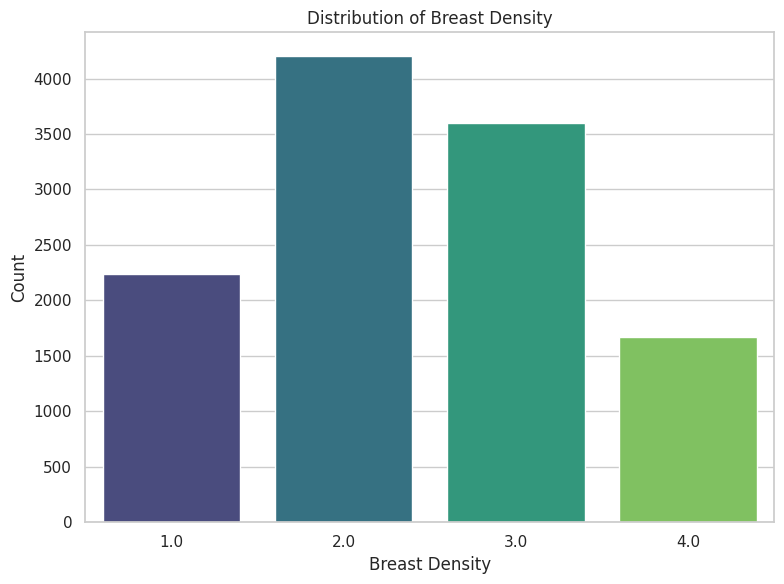

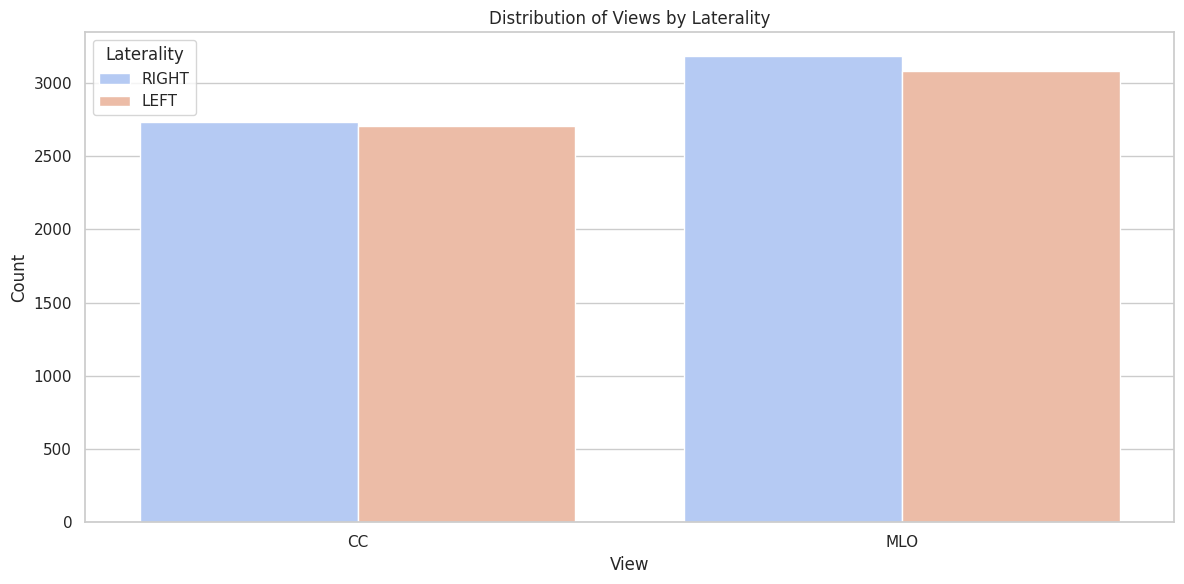

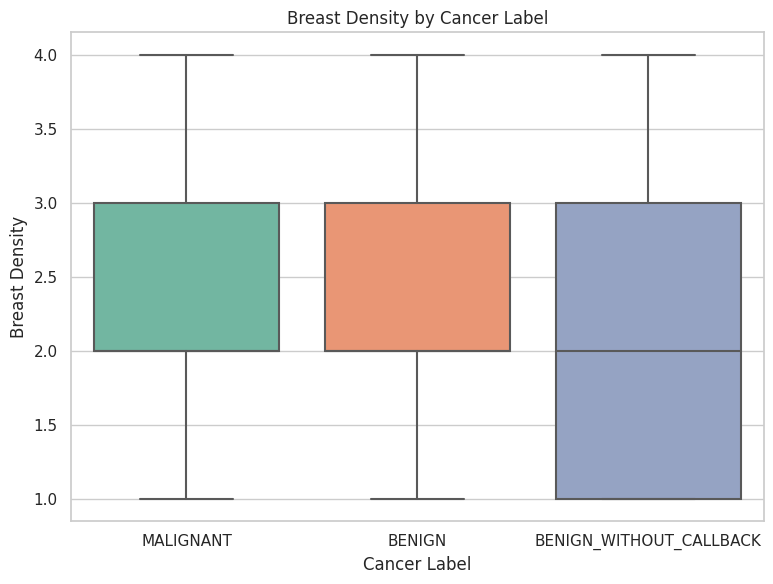

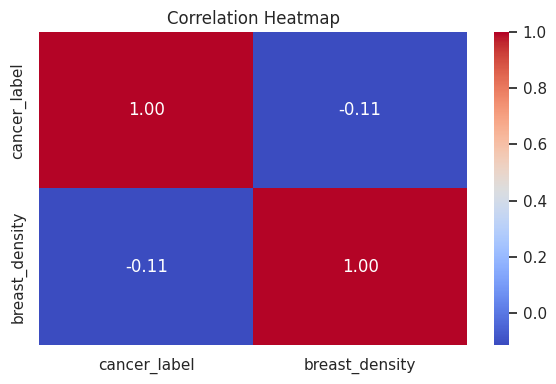

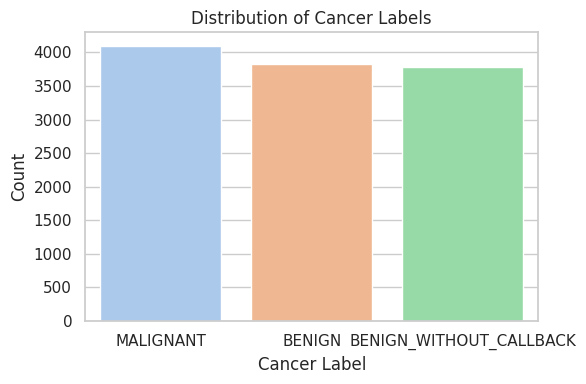

Number of records with missing image paths: 0
All image paths are correctly mapped.


In [5]:
# -------------------------------
# Data Visualization
# -------------------------------

def data_visualization(final_df):
    """
    Generate visualizations for the cleaned breast cancer dataset.
    
    Parameters:
        final_df (pd.DataFrame): The cleaned DataFrame containing the following columns:
                                 ['PatientID', 'Laterality', 'View', 'visit_number',
                                  'corrected_image_path', 'breast_density', 'cancer_label']
    """
    # Ensure that the DataFrame is not empty
    if final_df.empty:
        print("The final DataFrame is empty. No data available for visualization.")
        return
    
    # Set seaborn style for better aesthetics
    sns.set(style="whitegrid")
    
    # -------------------------------
    # Example 1: Distribution of 'breast_density'
    # -------------------------------
    plt.figure(figsize=(8, 6))
    sns.countplot(x='breast_density', data=final_df, palette='viridis')
    plt.title('Distribution of Breast Density')
    plt.xlabel('Breast Density')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Example 2: Distribution by Laterality and View
    # -------------------------------
    plt.figure(figsize=(12, 6))
    sns.countplot(x='View', hue='Laterality', data=final_df, palette='coolwarm')
    plt.title('Distribution of Views by Laterality')
    plt.xlabel('View')
    plt.ylabel('Count')
    plt.legend(title='Laterality')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Example 3: Breast Density by Cancer Label
    # -------------------------------
    # First, map cancer_label integers back to categorical labels if needed
    cancer_label_mapping = {
        0: 'BENIGN',
        1: 'MALIGNANT',
        2: 'BENIGN_WITHOUT_CALLBACK'
    }
    final_df['Cancer Label'] = final_df['cancer_label'].map(cancer_label_mapping)
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cancer Label', y='breast_density', data=final_df, palette='Set2')
    plt.title('Breast Density by Cancer Label')
    plt.xlabel('Cancer Label')
    plt.ylabel('Breast Density')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Example 4: Correlation Heatmap
    # -------------------------------
    # Select numerical columns for correlation
    numerical_cols = ['cancer_label', 'breast_density']
    correlation = final_df[numerical_cols].corr()
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Example 5: Distribution of Cancer Labels
    # -------------------------------
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Cancer Label', data=final_df, palette='pastel')
    plt.title('Distribution of Cancer Labels')
    plt.xlabel('Cancer Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Example 6: Pair Plot (Optional)
    # -------------------------------
    # This plot helps visualize relationships between multiple variables
    # Uncomment the following lines if you want to generate a pair plot
    """
    sns.pairplot(final_df, vars=['breast_density', 'cancer_label'], hue='Cancer Label', palette='Set1')
    plt.suptitle('Pair Plot of Breast Density and Cancer Label', y=1.02)
    plt.tight_layout()
    plt.show()
    """
    
    # -------------------------------
    # Example 7: Image Path Validation (Optional)
    # -------------------------------
    # If you wish to verify that image paths are valid and accessible
    # This can help in ensuring data integrity before any image processing tasks
    missing_image_paths = final_df['corrected_image_path'].isna().sum()
    print(f"Number of records with missing image paths: {missing_image_paths}")
    
    # Optionally, display some records with missing image paths
    if missing_image_paths > 0:
        print("\nSample records with missing image paths:")
        print(final_df[final_df['corrected_image_path'].isna()].head())
    else:
        print("All image paths are correctly mapped.")

# Execute the data visualization
data_visualization(final_df)


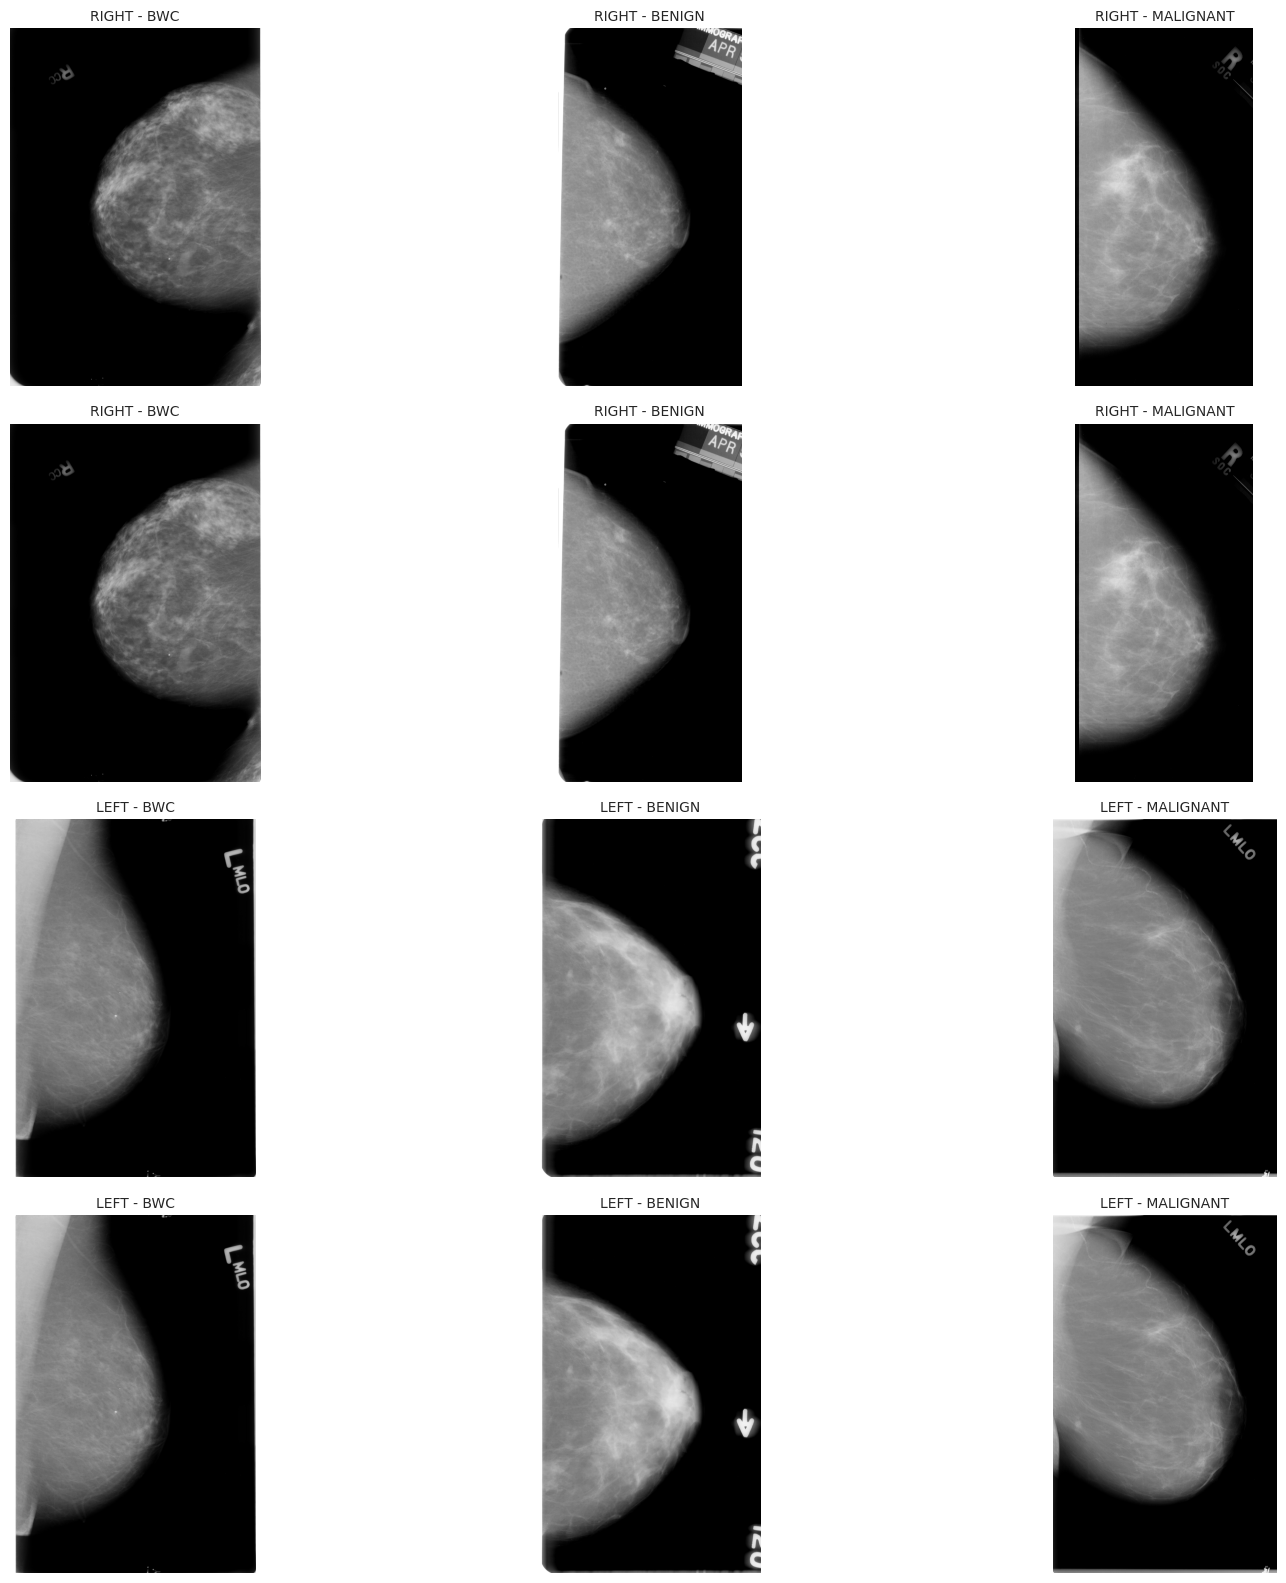

In [6]:
# Helper function to map numeric labels to text
def map_cancer_label(label):
    return {0.0: 'BENIGN', 1.0: 'MALIGNANT', 2.0: 'BWC'}.get(label, 'UNKNOWN')

# Helper function to load and display images
def plot_image(ax, image_path, title):
    try:
        img = mpimg.imread(image_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(title, fontsize=10)
    except Exception as e:
        ax.text(0.5, 0.5, 'Image Not Found', fontsize=8, ha='center')
        ax.axis('off')

# Helper function to sample images by laterality and cancer label
def sample_images(df, laterality, cancer_label, n=2):
    return df[(df['Laterality'] == laterality) & (df['cancer_label'] == cancer_label)].sample(n)

# Select two samples for each combination (Laterality + Cancer Label)
samples = {
    ('RIGHT', 2.0): sample_images(final_df, 'RIGHT', 2.0),  # BWC - Right
    ('RIGHT', 0.0): sample_images(final_df, 'RIGHT', 0.0),  # Benign - Right
    ('RIGHT', 1.0): sample_images(final_df, 'RIGHT', 1.0),  # Malignant - Right
    ('LEFT', 2.0): sample_images(final_df, 'LEFT', 2.0),   # BWC - Left
    ('LEFT', 0.0): sample_images(final_df, 'LEFT', 0.0),   # Benign - Left
    ('LEFT', 1.0): sample_images(final_df, 'LEFT', 1.0)    # Malignant - Left
}

# Create a 4x3 grid for visualization (Right-Right-Left-Left)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))

# Define the plot order for Right and Left laterality (2 rows each)
plot_order = [
    ('RIGHT', 2.0),  # BWC - Right (Top Left)
    ('RIGHT', 0.0),  # Benign - Right (Top Middle)
    ('RIGHT', 1.0),  # Malignant - Right (Top Right)
    
    ('RIGHT', 2.0),  # Second Right Row - BWC
    ('RIGHT', 0.0),  # Second Right Row - Benign
    ('RIGHT', 1.0),  # Second Right Row - Malignant

    ('LEFT', 2.0),   # BWC - Left
    ('LEFT', 0.0),   # Benign - Left
    ('LEFT', 1.0),   # Malignant - Left

    ('LEFT', 2.0),   # Second Left Row - BWC
    ('LEFT', 0.0),   # Second Left Row - Benign
    ('LEFT', 1.0)    # Second Left Row - Malignant
]

# Plot each image in the correct position
for idx, (laterality, cancer_label) in enumerate(plot_order):
    row = idx // 3  # Determine the row index
    col = idx % 3   # Determine the column index

    # Select the correct sample (first or second)
    sample_idx = 0 if row < 2 else 1
    sample_row = samples[(laterality, cancer_label)].iloc[sample_idx]
    
    label_text = map_cancer_label(cancer_label)
    title = f"{laterality} - {label_text}"

    # Plot the image
    plot_image(axes[row, col], sample_row['corrected_image_path'], title)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [7]:
%%capture
# Install necessary packages
!pip install tqdm
!pip install tensorflow
!pip install -U tensorflow-addons==0.18.0
!pip install scikit-learn
!pip install tf-keras-vis
!pip install opencv-python

In [8]:
# Import libraries
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import Progbar
import cv2

# Assuming final_df is already defined from the Data Cleaning section
# Ensure 'cancer_label' is of integer type
final_df['cancer_label'] = final_df['cancer_label'].astype(int)

# Split the data into train (70%), validation (15%), and test (15%)
train_val_df, test_df = train_test_split(
    final_df,
    test_size=0.15,
    random_state=42,
    stratify=final_df['cancer_label']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 of the total data
    random_state=42,
    stratify=train_val_df['cancer_label']
)

print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples\n")

Training set: 8198 samples
Validation set: 1758 samples
Test set: 1757 samples



In [9]:
# Convert integer labels to string for compatibility with 'sparse' class mode
train_df['cancer_label'] = train_df['cancer_label'].astype(str)
val_df['cancer_label'] = val_df['cancer_label'].astype(str)
test_df['cancer_label'] = test_df['cancer_label'].astype(str)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define target size and batch size
target_size = (380, 380)
batch_size = 8

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',  # Integer labels (as strings now)
    shuffle=True,
    seed=42,
    validate_filenames=True
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)

Found 8198 validated image filenames belonging to 3 classes.
Found 1758 validated image filenames belonging to 3 classes.
Found 1757 validated image filenames belonging to 3 classes.


In [10]:
final_df.tail()

,PatientID,Laterality,View,cancer_label,breast_density,corrected_image_path,Cancer Label
20713,Mass-Training_P_00731_RIGHT_CC_1,RIGHT,CC,0,2.0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,BENIGN
20714,Mass-Training_P_00731_RIGHT_CC_1,RIGHT,CC,0,2.0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,BENIGN
20717,Mass-Training_P_01461_RIGHT_MLO,RIGHT,MLO,1,2.0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,MALIGNANT
20718,Mass-Training_P_00314_RIGHT_MLO_1,RIGHT,MLO,1,1.0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,MALIGNANT
20719,Mass-Training_P_00314_RIGHT_MLO_1,RIGHT,MLO,1,1.0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,MALIGNANT


In [11]:
# Mapping numeric labels to text for clarity
label_mapping = {0: 'BENIGN', 1: 'MALIGNANT', 2: 'BWC'}

# Map the cancer_label column to text labels
final_df['Cancer_Label_Text'] = final_df['cancer_label'].map(label_mapping)

# Count the occurrences of each class
class_counts = final_df['Cancer_Label_Text'].value_counts()

# Print the counts
print("🔍 Class Distribution in the Dataset:\n")
for label, count in class_counts.items():
    print(f"{label}: {count} samples")

🔍 Class Distribution in the Dataset:

MALIGNANT: 4093 samples
BENIGN: 3831 samples
BWC: 3789 samples


In [12]:
# Check sample paths for correctness
print("Sample corrected image paths:")
print(train_df['corrected_image_path'].head())

# Verify file extensions
print("File extensions in the dataset:")
print(train_df['corrected_image_path'].apply(lambda x: os.path.splitext(x)[-1]).value_counts())

Sample corrected image paths:
1494     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
16434    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
18973    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
8966     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2408     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: corrected_image_path, dtype: object
File extensions in the dataset:
corrected_image_path
.jpg    8198
Name: count, dtype: int64


In [13]:
# Define the dataset root for JPEG images
jpeg_root = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/"

# Function to map .dcm paths to .jpg paths
def map_dcm_to_jpg(dcm_path):
    # Extract the folder ID (the DICOM directory structure)
    folder_id = dcm_path.split('/')[-2]
    
    # Search for corresponding JPEG image in the jpeg folder
    jpg_folder_path = os.path.join(jpeg_root, folder_id)
    
    if os.path.exists(jpg_folder_path):
        # List all JPEG files in that folder
        for file in os.listdir(jpg_folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                return os.path.join(jpg_folder_path, file)
    return None  # Return None if no match is found

# Apply the mapping function to all datasets
train_df['corrected_image_path'] = train_df['corrected_image_path'].apply(map_dcm_to_jpg)
val_df['corrected_image_path'] = val_df['corrected_image_path'].apply(map_dcm_to_jpg)
test_df['corrected_image_path'] = test_df['corrected_image_path'].apply(map_dcm_to_jpg)

# Check if the mapping worked
print("Updated corrected image paths (should now be .jpg):")
print(train_df['corrected_image_path'].head())


Updated corrected image paths (should now be .jpg):
1494     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
16434    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
18973    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
8966     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2408     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: corrected_image_path, dtype: object


In [14]:
# Enhanced Training Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  # Valid brightness adjustment
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (No Augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=(380, 380),
    batch_size=16,  # Increased batch size
    class_mode='sparse',
    shuffle=True,
    seed=42,
    validate_filenames=True,
    interpolation="bilinear"
)

# Validation Generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=(380, 380),
    batch_size=16,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)

# Test Generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='corrected_image_path',
    y_col='cancer_label',
    target_size=(380, 380),
    batch_size=16,
    class_mode='sparse',
    shuffle=False,
    validate_filenames=True
)

Found 8198 validated image filenames belonging to 3 classes.
Found 1758 validated image filenames belonging to 3 classes.
Found 1757 validated image filenames belonging to 3 classes.


In [15]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from tqdm.keras import TqdmCallback
import albumentations as A
import math

# ---------------------------------------------------
# 1) Focal Loss with Label Smoothing (static gamma)
# ---------------------------------------------------
def focal_loss_with_smoothing(gamma=2.0, alpha=0.25, smoothing=0.1):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_true = y_true * (1 - smoothing) + (smoothing / y_pred.shape[-1])

        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss_val = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss_val, axis=1))
    return loss

# ---------------------------------------------------
# 2) Build Model with DenseNet121
# ---------------------------------------------------
def build_model(input_shape=(380, 380, 3), num_classes=3, learning_rate=1e-4):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze more layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Example: Cosine decay schedule (replace this with your steps)
    total_steps = 10000
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=total_steps,
        alpha=0.01
    )

    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss_with_smoothing(gamma=2.0, alpha=0.25, smoothing=0.1),
        metrics=['accuracy']
    )
    return model

model = build_model()

# ---------------------------------------------------
# 3) Compute Class Weights from training labels
# ---------------------------------------------------
train_labels = train_df['cancer_label'].values
cw_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(cw_array))
print("Class Weights:", class_weights_dict)

# ---------------------------------------------------
# 4) Albumentations-based augmentation
# ---------------------------------------------------
train_aug = A.Compose([
    A.RandomResizedCrop(380, 380, scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.CLAHE(clip_limit=(1,4), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_aug = A.Compose([
    A.Resize(380, 380),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# (You need to implement your albumentations_generator or use a library that supports it.)

# ---------------------------------------------------
# 5) Callbacks
# ---------------------------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    TqdmCallback(verbose=1)
    # Remove or keep ReduceLROnPlateau if desired, but it's redundant with CosineDecay
]

# ---------------------------------------------------
# 6) Training
# ---------------------------------------------------
history = model.fit(
    train_generator,  # your custom or standard generator with augmentation
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights_dict,  # apply class weighting
    verbose=0
)

# ---------------------------------------------------
# 7) Evaluation
# ---------------------------------------------------
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")

model.save("improved_breast_cancer_model.keras")
print("💾 Model saved successfully!")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Class Weights: {0: 1.0192714161382568, 1: 0.9538103548574752, 2: 1.0304172951231774}


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_loss improved from inf to 4.02906, saving model to best_model.keras

Epoch 2: val_loss improved from 4.02906 to 4.00479, saving model to best_model.keras

Epoch 3: val_loss improved from 4.00479 to 1.73269, saving model to best_model.keras

Epoch 4: val_loss improved from 1.73269 to 1.71611, saving model to best_model.keras

Epoch 5: val_loss improved from 1.71611 to 0.70777, saving model to best_model.keras

Epoch 6: val_loss improved from 0.70777 to 0.69821, saving model to best_model.keras

Epoch 7: val_loss improved from 0.69821 to 0.29970, saving model to best_model.keras

Epoch 8: val_loss improved from 0.29970 to 0.29477, saving model to best_model.keras

Epoch 9: val_loss improved from 0.29477 to 0.14823, saving model to best_model.keras

Epoch 10: val_loss improved from 0.14823 to 0.13793, saving model to best_model.keras

Epoch 11: val_loss improved from 0.13793 to 0.10437, saving model to best_model.keras

Epoch 12: val_loss improved from 0.10437 to 0.09136, sa

219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 621ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.34      0.44       575
           1       0.60      0.89      0.72       614
           2       0.90      0.86      0.88       568

    accuracy                           0.70      1757
   macro avg       0.71      0.70      0.68      1757
weighted avg       0.71      0.70      0.68      1757



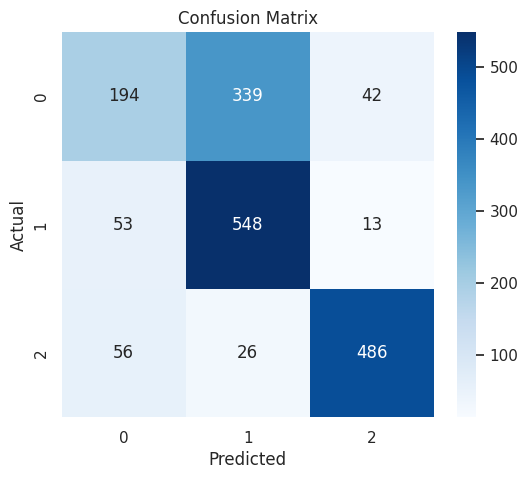

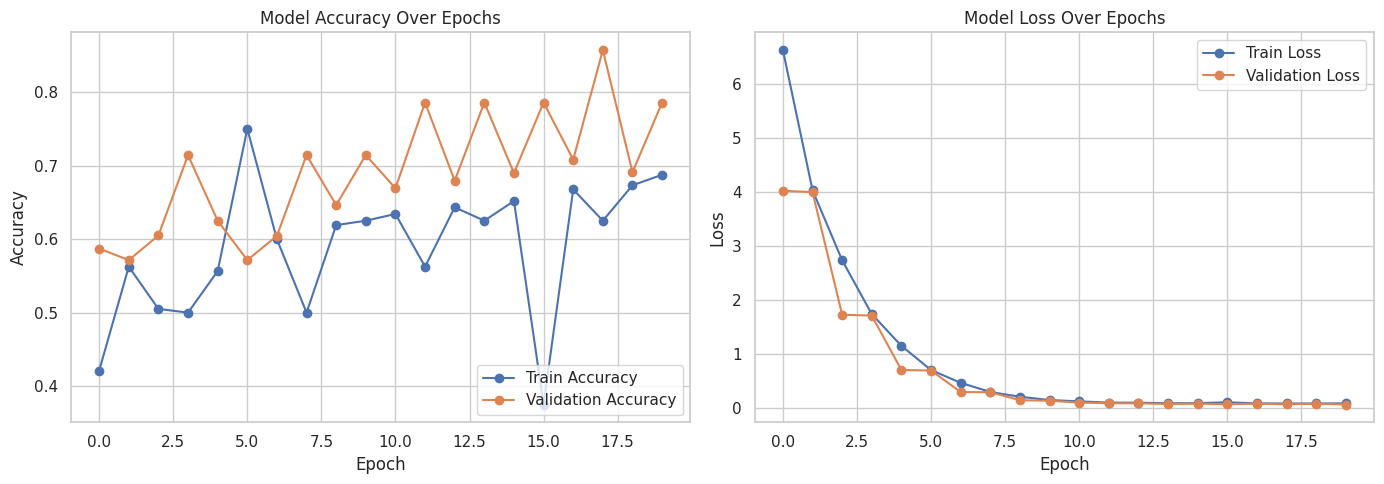

In [16]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=1)
# print(f"\nTest Accuracy: {test_accuracy:.4f}")
# print(f"Test Loss: {test_loss:.4f}\n")

# Predict classes on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes[:len(y_pred)]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys()))
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Using last convolutional layer: conv5_block16_concat


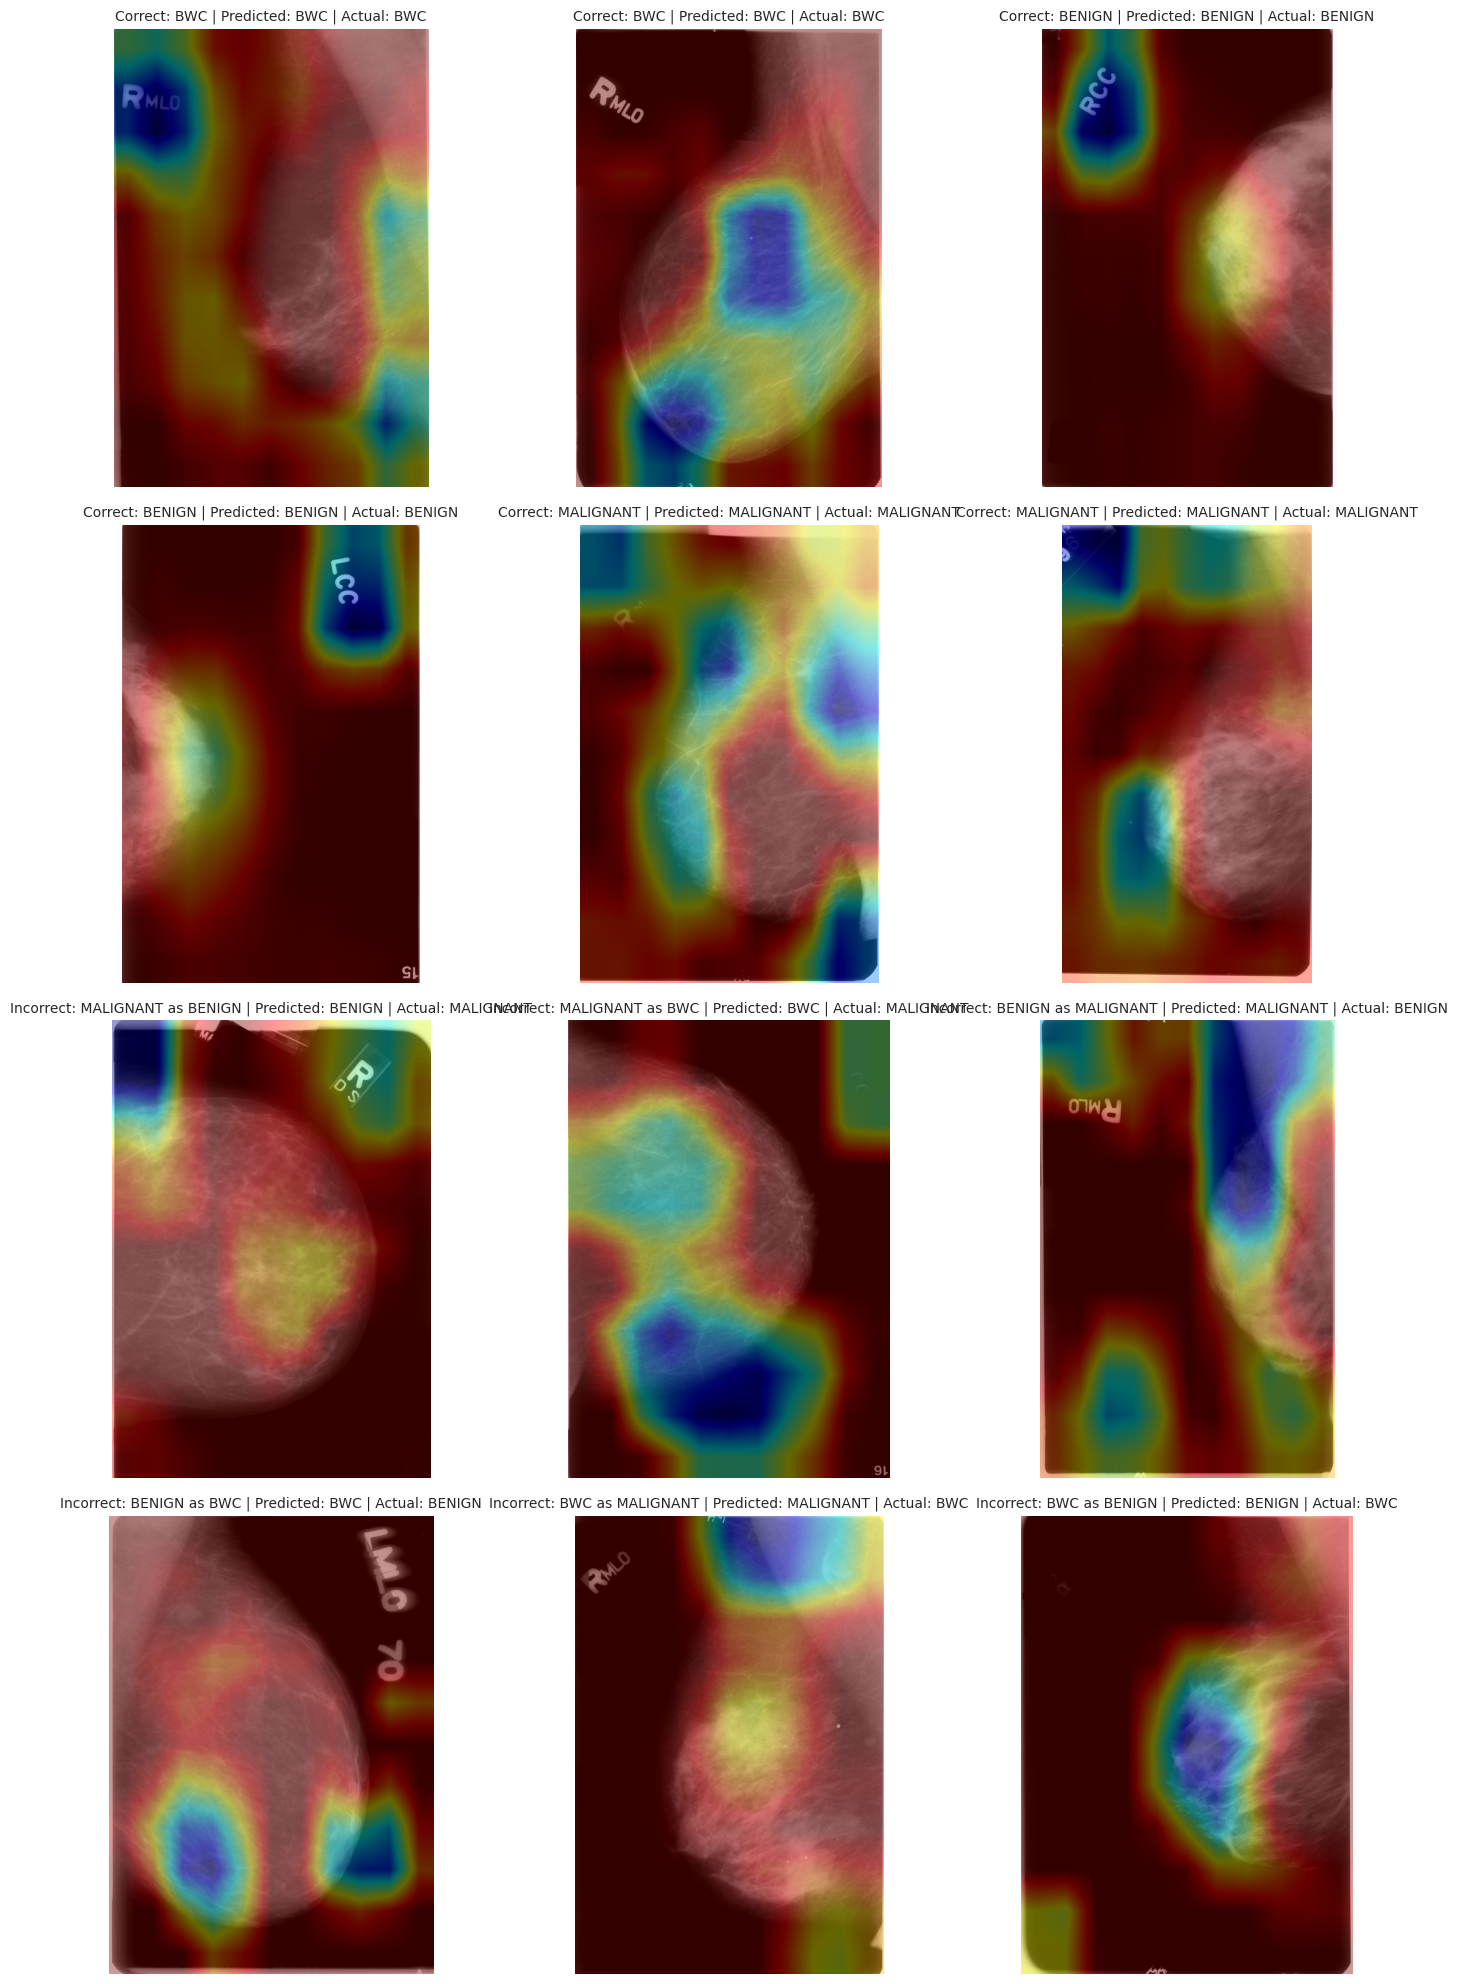

In [19]:
# Mapping numeric cancer labels to text
def map_cancer_label(label):
    return {0: 'BENIGN', 1: 'MALIGNANT', 2: 'BWC'}.get(label, 'UNKNOWN')

# Function to generate Grad-CAM heatmaps
def generate_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)  # Disable training mode
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay the heatmap on the original image
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    return cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

# Identify the last convolutional layer in the model
last_conv_layer_name = 'top_conv'
for layer in model.layers:
    if 'conv' in layer.name.lower():
        last_conv_layer_name = layer.name

print(f"Using last convolutional layer: {last_conv_layer_name}")

# Prepare categories for specific prediction scenarios
correct_bwc, correct_benign, correct_malignant = [], [], []
incorrect_mal_as_benign, incorrect_mal_as_bwc = [], []
incorrect_benign_as_mal, incorrect_benign_as_bwc = [], []
incorrect_bwc_as_mal, incorrect_bwc_as_benign = [], []

# Iterate over test samples
for idx, row in test_df.iterrows():
    img_path = row['corrected_image_path']
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    # Suppress verbose output during prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    actual_class = int(row['cancer_label'])

    result = {
        'image': img_rgb,
        'predicted': predicted_class,
        'actual': actual_class,
        'heatmap': generate_gradcam(model, img_array, last_conv_layer_name)
    }

    # Correct Predictions
    if predicted_class == actual_class:
        if actual_class == 2 and len(correct_bwc) < 2:
            correct_bwc.append(result)
        elif actual_class == 0 and len(correct_benign) < 2:
            correct_benign.append(result)
        elif actual_class == 1 and len(correct_malignant) < 2:
            correct_malignant.append(result)
    
    # Incorrect Predictions
    else:
        if actual_class == 1:
            if predicted_class == 0 and len(incorrect_mal_as_benign) < 1:
                incorrect_mal_as_benign.append(result)
            elif predicted_class == 2 and len(incorrect_mal_as_bwc) < 1:
                incorrect_mal_as_bwc.append(result)

        if actual_class == 0:
            if predicted_class == 1 and len(incorrect_benign_as_mal) < 1:
                incorrect_benign_as_mal.append(result)
            elif predicted_class == 2 and len(incorrect_benign_as_bwc) < 1:
                incorrect_benign_as_bwc.append(result)

        if actual_class == 2:
            if predicted_class == 1 and len(incorrect_bwc_as_mal) < 1:
                incorrect_bwc_as_mal.append(result)
            elif predicted_class == 0 and len(incorrect_bwc_as_benign) < 1:
                incorrect_bwc_as_benign.append(result)

    if (len(correct_bwc) == 2 and len(correct_benign) == 2 and len(correct_malignant) == 2 and
        len(incorrect_mal_as_benign) == 1 and len(incorrect_mal_as_bwc) == 1 and
        len(incorrect_benign_as_mal) == 1 and len(incorrect_benign_as_bwc) == 1 and
        len(incorrect_bwc_as_mal) == 1 and len(incorrect_bwc_as_benign) == 1):
        break

# Combine results for plotting (dynamic adjustment)
combined_results = (
    correct_bwc + correct_benign + correct_malignant +
    incorrect_mal_as_benign + incorrect_mal_as_bwc +
    incorrect_benign_as_mal + incorrect_benign_as_bwc +
    incorrect_bwc_as_mal + incorrect_bwc_as_benign
)

titles = [
    "Correct: BWC", "Correct: BWC",
    "Correct: BENIGN", "Correct: BENIGN",
    "Correct: MALIGNANT", "Correct: MALIGNANT",
    "Incorrect: MALIGNANT as BENIGN", "Incorrect: MALIGNANT as BWC",
    "Incorrect: BENIGN as MALIGNANT", "Incorrect: BENIGN as BWC",
    "Incorrect: BWC as MALIGNANT", "Incorrect: BWC as BENIGN"
]

titles = titles[:len(combined_results)]

cols = 3
rows = -(-len(combined_results) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

for i, result in enumerate(combined_results):
    superimposed_img = superimpose_heatmap(result['image'], result['heatmap'])
    predicted_label = map_cancer_label(result['predicted'])
    actual_label = map_cancer_label(result['actual'])
    
    axes[i].imshow(superimposed_img)
    axes[i].axis('off')
    axes[i].set_title(f"{titles[i]} | Predicted: {predicted_label} | Actual: {actual_label}", fontsize=10)

for j in range(len(combined_results), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Save the final model
model.save('breast_cancer_classification_model_efficientnetb7.h5')
print("Model saved as 'breast_cancer_classification_model_efficientnetb7.h5'")


Model saved as 'breast_cancer_classification_model_efficientnetb7.h5'
